[12:58:55]  :  32.0%  1.1s/3.3s  ETA: 12:58:58 [T-2.2s]
[12:58:57]   complete in 2.465s


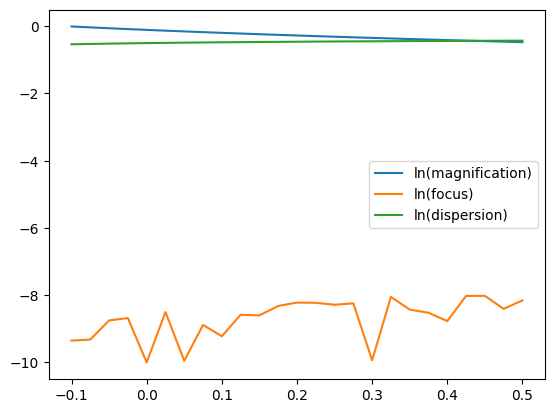

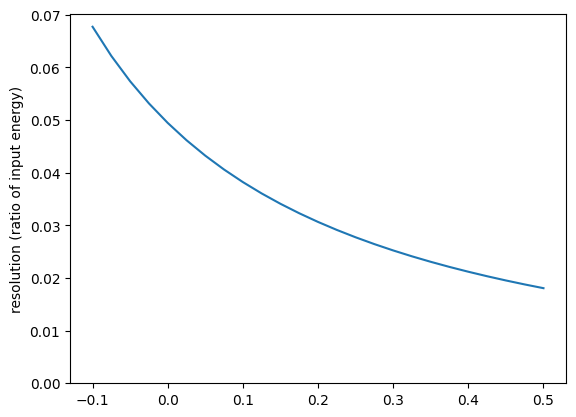

In [57]:
import cosy
import acceptance
import numpy as np
import util
import matplotlib.pyplot as plt

K_p_bend_radius = "p_bend_radius"
K_p_bend_angle = "p_bend_angle"
K_p_drift_post_aperture = "p_drift_post_aperture"
K_p_drift_pre_bend = "p_drift_pre_bend"
K_p_drift_post_bend = "p_drift_post_bend"
K_p_drift_pre_hodoscope = "p_drift_pre_hodoscope"
K_p_m5a_length = "p_m5a_length"
K_p_m5a_quad = "p_m5a_quad"
K_p_m5b_length = "p_m5b_length"
K_p_m5b_quad = "p_m5b_quad"
K_shape_in_1 = "shape_in_1"
K_shape_out_1 = "shape_out_1"

arg_vals = {
    K_p_bend_radius: 0.2021197079306207,
    K_p_bend_angle: 93.884579505768,
    K_p_drift_post_aperture: 0.001647845131336711,
    K_p_drift_pre_bend: 0.08264476762309475,
    K_p_drift_post_bend: 0.07893060501596277,
    K_p_drift_pre_hodoscope: 0.07422094266888424,
    #   K_p_drift_pre_hodoscope: 0.2,
    K_p_m5a_length: 0.1,
    #   K_p_m5a_length: 0.06981600194372625,
    K_p_m5a_quad: 0.1293780028644797,
    K_p_m5b_length: 0.06928842409139782,
    K_p_m5b_quad: 0.1179451296465932,
    K_shape_in_1: -0.1249745550920304,
    K_shape_out_1: -0.10147496294559,
}


def gen_charictaristic_rays(
    r_foil: float,
    l_drift: float,
    r_aperture: float,
    n: int,
):

    a = np.linspace(-1, 1, n)
    x0 = (
        np.expand_dims(a * r_foil, axis=(1, 2, 3))
        .repeat(n, axis=1)
        .repeat(n, axis=2)
        .repeat(n, axis=3)
    )
    y0 = (
        np.expand_dims(a * r_foil, axis=(0, 2, 3))
        .repeat(n, axis=0)
        .repeat(n, axis=2)
        .repeat(n, axis=3)
    )
    x1 = (
        np.expand_dims(a * r_aperture, axis=(0, 1, 3))
        .repeat(n, axis=0)
        .repeat(n, axis=1)
        .repeat(n, axis=3)
    )
    y1 = (
        np.expand_dims(a * r_aperture, axis=(0, 1, 2))
        .repeat(n, axis=0)
        .repeat(n, axis=1)
        .repeat(n, axis=2)
    )
    valid = (x0**2 + y0**2 <= r_foil**2) & (x1**2 + y1**2 <= r_aperture**2)
    x0 = x0[valid]
    y0 = y0[valid]
    x1 = x1[valid]
    y1 = y1[valid]

    return {
        "input_rays": acceptance.relative_rays_into_cosyscript(
            np.transpose(
                [
                    x1,
                    (x1 - x0) / l_drift,
                    y1,
                    (y1 - y0) / l_drift,
                    np.zeros_like(x1),
                ]
            ),
            color=5,
        )
    }


FIT_ALGO_SYMPLECTIC = 1
FIT_ALGO_NEWTONS_METHOD = 4
FIT_ALGO_SIMULATED_ANNEAL = 3


def enable_fit(
    fit_args: list[str],
    n_max=1000,
    algorithm=FIT_ALGO_NEWTONS_METHOD,
    tolerance=1e-5,
):
    return {
        "do_fit": True,
        "fit_args": " ".join(fit_args),
        "fit_n_max": n_max,
        "fit_algorithm": algorithm,
        "fit_tolerance": tolerance,
    }


def disable_fit():
    return {
        "do_fit": False,
        "fit_n_max": 0,
        "fit_algorithm": 0,
        "fit_tolerance": 0,
        "fit_args": K_p_m5a_quad,
    }


def config_general(
    order=1,
    outputs: list[str] = [],
):
    return {
        "order": order,
        "outputs": " ".join(outputs),
    }

R_FOIL = 0.015
L_DRIFT = 0.25
R_APERTURE = 0.01
input_rays = gen_charictaristic_rays(
    r_foil=R_FOIL,
    l_drift=L_DRIFT,
    r_aperture=R_APERTURE,
    n=3,
)

x = np.linspace(-0.1, 0.5, 25)
v = []
a = []
timer = util.begin_timer("")
for i in range(x.size):
    arg_vals[K_p_m5a_quad] = x[i]
    out = cosy.read_sub_eval(
        "./m.fox",
        arg_vals
        | enable_fit([K_p_drift_pre_hodoscope], n_max=500, algorithm=FIT_ALGO_NEWTONS_METHOD,tolerance=1e-8)
        # | disable_fit()
        | cosy.INCLUDE_UTILS
        | config_general(
            order=3,
            outputs=["ME(1,1)","ME(1,2)","ME(1,6)"]
        )
        | input_rays,
        use_gui=False,
    )()
    params, out = cosy.parse_write_dict(out)
    _, outputs, out = cosy.parse_write(out)
    out_map, out = cosy.parse_transfer_map(out)
    a.append(params)
    v.append(outputs)
    timer((i + 1) / x.size)
v = np.array(v)

# plt.plot(x, 0*x, "--k")
# plt.plot(x, v[:,0])
# plt.plot(x, v[:,1])
# plt.plot(x, v[:,2])
# plt.legend([
#     "zero (reference)",
#     "magnification",
#     "focus",
#     "dispersion",
# ])
# plt.show()
plt.plot(x, np.log10(np.abs(v[:,0])))
plt.plot(x, np.log10(np.abs(v[:,1])))
plt.plot(x, np.log10(np.abs(v[:,2])))
plt.legend([
    "ln(magnification)",
    "ln(focus)",
    "ln(dispersion)",
])
plt.show()
plt.ylabel("resolution (ratio of input energy)")
plt.plot(x, np.abs(2*R_APERTURE*v[:, 0] / v[:, 2]))
plt.ylim(bottom=0)
plt.show()

In [58]:
out = cosy.read_sub_eval(
    "./m.fox",
    a[np.searchsorted(x, 0.2)]
    | disable_fit()
    | cosy.INCLUDE_UTILS
    | config_general(outputs=["ME(1,2)"],order=3)
    | input_rays,
    use_gui=True,
)()
print(out)

p_bend_radius
 0.2021197079306207     
p_bend_angle
  93.88457950576800     
p_drift_post_aperture
 0.5000000000000000E-001
p_drift_pre_bend
 0.8264476762309475E-001
p_drift_post_bend
 0.7893060501596277E-001
p_drift_pre_hodoscope
 0.1614106675112069     
p_m5a_length
 0.1000000000000000     
p_m5a_quad
 0.2250000000000000     
p_m5b_length
 0.6928842409139782E-001
p_m5b_quad
 0.1179451296465932     
shape_in_1
 -.1249745550920304     
shape_out_1
 -.1014749629455900     

outputs
 0.5920076984189393E-008

 -0.5077681     -12.17470      0.000000      0.000000     -3.805775     100000
  0.5920077E-08 -1.969403      0.000000      0.000000    -0.6864858     010000
   0.000000      0.000000     -3.647260     -8.248936      0.000000     001000
   0.000000      0.000000     0.3323844     0.4775689      0.000000     000100
   0.000000      0.000000      0.000000      0.000000      1.000000     000010
  0.3485757     0.8626547      0.000000      0.000000    -0.1212228     000001
  -17.03832   

In [43]:
cosy.parse_write_dict(out)

({'p_bend_radius': np.float64(0.2021197079306207),
  'p_bend_angle': np.float64(93.884579505768),
  'p_drift_post_aperture': np.float64(0.001647845131336711),
  'p_drift_pre_bend': np.float64(0.08264476762309475),
  'p_drift_post_bend': np.float64(0.07893060501596277),
  'p_drift_pre_hodoscope': np.float64(0.07422094266888424),
  'p_m5a_length': np.float64(0.06981600194372625),
  'p_m5a_quad': np.float64(0.1293780028644797),
  'p_m5b_length': np.float64(0.06928842409139782),
  'p_m5b_quad': np.float64(0.1179451296465932),
  'shape_in_1': np.float64(-0.1249745550920304),
  'shape_out_1': np.float64(-0.10147496294559)},
 '')